<a href="https://colab.research.google.com/github/cdarbelaez/SolarForecastingElecEngUdeA/blob/main/MODELOS%20SINTONIZADOS/CNN_GRU_Sintonizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN_GRU NN MULTIVARIABLE MINMAX**

---


> En este notebook se realiza la implementación de la red neuronal mencionada: 

*   Se parte del preprocesamiento y análisis de los datos que **NO** está incluido en este script.
*   Luego se procede a cargar y escalar el dataset previamente procesado.
*   Se preparan en ventanas y se separan en set de entrenamiento y validación.
*   Luego se implementa el modelo de aprendizaje automatico con una arquitectura e hiperparametros previamente establecidos.
*   Por último se validan los resultados y se obtienen las métricas de error.

> La diferencia principal de este modelo con los demás CNN_GRU es que se utiliza para escalar los datos la función de sklearn `MinMaxScaler()` y variables exogenas multiples de entrada al modelo.



---

**BASE DE DATOS:** KENYA




---
# 1.   **SE IMPORTAN LAS BIBLIOTECAS NECESARIAS**

---

  Importamos las librerias necesarias para todo el script: 

1.   **Matplotlib** para realizar las gráficas
2.   **Pandas** para procesar la base de datos
3.   **Numpy** para convertir la base de datos en arreglos numéricos
4.   **Os** para acceder a los archivos mediante rutas de almacenamiento
5.   **Seaborn** para realizar análisis gráficos a los datos mediante análisis estadisticos
6.   **Drive** se utiliza para acceder a las carpetas de datos del drive de un correo asociado
7.   **Tensorflow** es la librería mediante la cual se generan los modelos de redes neuronales



In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 5.0 MB/s 


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from kerastuner import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from google.colab import drive 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6) #Definimos el tamaño para las figuras de matplotlib
mpl.rcParams['axes.grid'] = False



---


# 2.   **SE CARGA EL DATASET PREVIAMENTE PROCESADO**

---





En la siguiente celda de codigo se llama una función de google colab mediante la cual se accede a la carpeta de drive, luego se define la ruta de acceso a la base de datos previamente procesados para la realización del modelo y se procesa mediante la librería `Pandas`:

In [ ]:
ruta= 'https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv'
ruta='https://raw.githubusercontent.com/cdarbelaez/SolarForecastingElecEngUdeA/main/DATABASES/KENYA_LIMPIO.csv'
data = pd.read_csv(ruta,encoding='utf-8') # Se hace la respectiva lectura, no se añade encabezado o indice, por lo que pondrá por defecto la numeracion
if ruta=='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv':
  data.set_index('datetime', inplace=True)
else:
  data.set_index('time', inplace=True) # Establecemos cual será el indice del dataframe
data.head(2) # Se muestran las 5 primeras filas del dataframe

,dhi_pyr,ghi_pyr_1,ghi_pyr_2,air_temperature,relative_humidity,barometric_pressure,precipitation,wind_speed,wind_from_direction,gti_clean,gti_soil,gti_monthly,sensor_cleaning,Hour
time,,,,,,,,,,,,,,
2019-12-12 00:00:00,0.0,0.0,0.0,22.72500,99.003998,948.445923,0.0,1.073283,169.845993,0.0,0.0,0.0,0.0,0
2019-12-12 00:15:00,0.0,0.0,0.0,22.58083,98.758003,948.415283,0.0,0.727417,204.165405,0.0,0.0,0.0,0.0,0




---


# 3. **SE SELECCIONAN LOS DATOS A UTILIZAR PARA EL ENTRENAMIENTO DEL MODELO**


---



In [ ]:
if ruta=='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv':
  features_considered = ['GHI','Precipitation',	'DOY','PST','Precipitation', 'Zenith',	'Humidity'] # Definimos las columnas que se van a utilizar para el entrenamiento del modelo
  features = data[features_considered].loc['2010-04-07 00:00:00':] # Creamos un dataframe con solo estos datos
else:
  features_considered = ['ghi_pyr_1']#,'precipitation','relative_humidity','Hour','wind_speed']
  features = data[features_considered] # Creamos un dataframe con solo estos datos
features.head() #Se muestran los 5 primeros datos

,ghi_pyr_1
time,
2019-12-12 00:00:00,0.0
2019-12-12 00:15:00,0.0
2019-12-12 00:30:00,0.0
2019-12-12 00:45:00,0.0
2019-12-12 01:00:00,0.0


Graficamos todos los datos con el fin de apreciar de manera general su comportamiento a lo largo del tiempo con la función plot asociada a la librería `Pandas`.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3871a9910>],
      dtype=object)

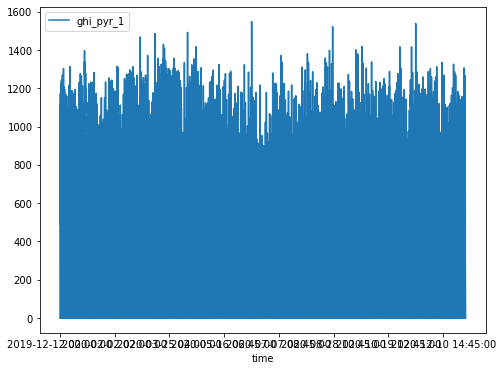

In [ ]:
features.plot(subplots=True) # Graficamos las columnas de datos para observar su comportamiento

Se convierte el conjunto de datos en un arreglo de `numpy` definiendo la cantidad de datos que se van a utilizar para el proceso y luego se estandarizan con una normalización:




---


3_1. **ESCALAMIENTO DE LOS DATOS**


---


In [ ]:
if ruta=='https://raw.githubusercontent.com/alvarojd/SolarForecasting/main/DATASETS/INICIAL_LIMPIO.csv':
  estandar=data['GHI'].values.reshape(len(data),1)
else:
  estandar=data['ghi_pyr_1'].values.reshape(len(data),1)
scaler = MinMaxScaler()
dataset = scaler.fit_transform(estandar)

In [ ]:
TRAIN_SPLIT = int(len(features)*0.8//1) #Definimos la cantidad de datos que se van a usar para el entrenamiento del modelo
STEP=1
dataset = features.values # Convertimos el dataframe en un arreglo de numpy
#data_mean = dataset[:TRAIN_SPLIT,0].mean(axis=0) # Se obtiene la media estadistica de los datos
data_max = dataset[:TRAIN_SPLIT,0].max(axis=0) # Se obtiene la desviación estandar de los datos

dataset = (dataset)/data_max #Se normaliza cada dato del arreglo para que todos los valores esten entre -1 y 1



---


# 4.   **SE DEFINE LA FUNCIÓN QUE SE UTILIZA PARA LA PARTICIÓN DE LOS DATOS EN VENTANAS**

--- 

In [ ]:
#---------------------------------------
#CONFIGURACIÓN DE LAS VENTANAS DE DATOS#
#---------------------------------------
DATASPLIT = 0.8                        #
Num_datos_entrada = 96                 #
Num_datos_salida = 96                  #
#---------------------------------------

def ventanas(dataset,xsize,ysize,split,validation= False):
  #dataset: Es un array de numpy obtenido a partir del dataframe de pandas, en este están contenidos todos los datos que se utilizarán
  #split: porcentaje del dataset a utilizar
  #xsize: Número entero, determina el tamaño de la ventana de caracteristicas (Entradas del modelo)
  #ysize: Número entero, determina el tamaño de la ventana de etiquetas (Salidas del modelo)
  #validation: Si es True, toma el porcentaje restante de los datos como set, de lo contrario toma el porcentaje indicado

  if validation!=True: #Se generan los índices para tomar los días exactos para el set de entrenamiento
    indexin=int(0)
    indexf=int((((len(dataset)*split)//xsize)*xsize))
  else: #Se generan los índices para tomar los días exactos para el set de validación
    indexin=int((((len(dataset)*split)//xsize)*xsize))
    indexf=int(len(dataset))
  n=0 # Indexador
  x=[] # Lista vacia donde estarán contenidas las ventanas de datos de entrada (Caracteristicas)
  y=[] # Lista vacia donde estarán contenidas las ventanas de datos de salida (Etiquetas)
  
  for i in range(int(((indexf-indexin)/ysize)-1)): #Este ciclo se repite el número de veces como ventanas habrán en un arreglo de datos
                                                   # Ejemplo: dataset= [1,2,3,4,5,6]
                                                   # indexf=6, indexin=0, xsize=2, ysize=2
                                                   # range= (3-1) = 2  <------ Ya que se obtendrán 3 ventanas de datos
                                                   # Al resultado se le resta uno para considerar que la ultima ventana tambien contenga datos en "y"
                                                   
    x.append(dataset[n+indexin:n+indexin+xsize].T) #Se agrega a la lista la ventana de datos utilizando la idexación 
                                                   # Ejemplo: dataset= [1,2,3,4,5,6]
                                                   # Primera iteración:
                                                   #  x=[[1,2]]
                                                   # Segunda iteración:
                                                   #  x=[[1,2],[3,4]]

    y.append(dataset[n+indexin+xsize:n+indexin+xsize+ysize].T[0])
                                                   # Siguiendo el ejemplo anterior
                                                   #  y=[[3,4]]
                                                   # Segunda iteración:
                                                   #  y=[[3,4],[5,6]]
    
                                                   # Siguiento el ejemplo, los las ventanas listas para entrar al modelo quedan de la siguiente manera
                                                   # x = [[1,2],[3,4]]
                                                   # y = [[3,4],[5,6]]

    n+=ysize # Se suma al indexador el tamaño de la ventana
    
  return np.array(x),np.array(y)

x_train1, y_train1= ventanas(dataset, xsize= Num_datos_entrada, ysize= Num_datos_salida, split = DATASPLIT)
x_val1,y_val1=ventanas(dataset, xsize= Num_datos_entrada, ysize= Num_datos_salida, split = DATASPLIT, validation=True)

In [ ]:
x_train1[0].shape

(1, 96)



---


# 5.   **FUNCIÓN PARA VISUALIZAR LOS RESULTADOS OBTENIDOS**


---


La siguiente de función se utiliza para generar gráficos a partir de una ventana de tiempo como las que se definieron anteriormente, esta se utilizará para mostrar:

*   La ventana de tiempo utilizada para la predicción
*   El valor real de los datos futuros tomado del set de validación
*   El valor de las predicciones que arroja la red neuronal



In [ ]:
def create_time_steps(length): # Función que crea un array en un rango determinado por el tamaño de la ventana de datos
    return list(range(-length, 0))

# history: Un arreglo con la ventana de datos usada para la predicción
# true_future: Arreglo con los datos conocidos que deberia arrojar la predicción 
# prediction: Arreglo con las predicciones obtenidas

def multi_step_plot(history, true_future, prediction): 
    plt.figure(figsize=(12, 6)) # Se define el tamaño de la figura
    num_in = create_time_steps(len(history)) #Tamaño de la curva de datos pasados
    num_out = len(true_future) # Tamaño de la curva de datos futuros
    plt.plot(num_in, history, label='History') # Graficamos datos pasados
    plt.plot(np.arange(num_out)/STEP, (true_future), 'y--',
           label='True Future') #Graficamos datos furutos
    if prediction.any(): # Si se ingresan datos sobre las predicciones
        plt.plot(np.arange(num_out)/STEP, (prediction), 'r--', #Grafica tambien las predicciones
                 label='Predicted Future')
    plt.legend(loc='upper left') # Ajustes de la grafica
    plt.grid()
    plt.show() # Se muestra la grafica

---
 # 6. **CREACIÓN Y ENTRENAMIENTO DEL MODELO**
 ---

**GRU**: Es una parte de un modelo de red neuronal recurrente, que ayuda a ajustar los pesos de las entradas para resolver el problema del gradiente de desaparición, que es uno de los problemas que tienen las redes neuronales recurrentes el cual no les permite mantener la información a medida que se pasa de una red neuronal a otra.

En las siguientes celdas se va a definir el modelo de ML que se utilizará para realizar las predicciones buscadas, este modelo consta de una capa de entrada, y dos capas intermedias de neuronas tipo LSTM, con una respectiva función de activación.

![RedNeuronalArtificial.png](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Gated_Recurrent_Unit.svg/470px-Gated_Recurrent_Unit.svg.png)

Fig 1. [Diagrama de una red GRU](https://es.wikipedia.org/wiki/Perceptr%C3%B3n_multicapa)

La cantidad de neuronas ajustada de forma manual para maximizar su precisión de entrenamiento y una capa de salida con n neuronas con n datos de predicción buscados.

Además se compila el modelo y dentro de dicha compilación estan incluidas configuraciónes, donde las configuraciones son:

*   **optimizer**: Optimizador utilizado
*   **loss**: Métrica utilizada para determinar las perdidas del modelo
*   **metrics**: Guarda los valores de las metricas en cada epoca de entrenamiento

[Referencia](https://es.frwiki.wiki/wiki/R%C3%A9seau_de_neurones_r%C3%A9currents)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.03):
      print("\nReached less than 0.02 losses so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=70)

In [ ]:
batch_size=1

In [ ]:
def build_model(hp):
  
  activacion =  hp.Choice('Activación' , ['tanh', 'relu' , 'sigmoid', 'softmax', 'gelu', 'elu'])
  neuronas_c1 = hp.Int('Units1', min_value = 20, max_value = 200, step = 20)
  neuronas_c2 = hp.Int('Units2', min_value = 20, max_value = 200, step = 20)
  filtros = hp.Int('Filters', min_value = 32, max_value = 160, step = 32)
  dropout = hp.Float('Dropout', min_value = 0.1, max_value = 0.3, step = 0.05)
  model = tf.keras.models.Sequential([
      tf.keras.layers.GRU(neuronas_c1, activation = activacion , stateful= True, dropout = dropout, return_sequences=True,batch_input_shape= (batch_size, x_train1.shape[1], x_train1.shape[2])),
      tf.keras.layers.Conv1D(filters=filtros, kernel_size=3,padding="causal",activation= activacion ,kernel_initializer= 'he_uniform'),
      tf.keras.layers.GRU(neuronas_c2, activation= activacion , stateful= True, dropout = dropout),
      tf.keras.layers.Dense(96)
  ])
  
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
  hp_optimizers = hp.Choice('Optimizer', values = ['adam', 'adamax','nadam','RMSprop','SGD'])
  if hp_optimizers == 'adam':
    opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  if hp_optimizers == 'adamax':
    opt = tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate)
  if hp_optimizers == 'nadam':
    opt = tf.keras.optimizers.Nadam(learning_rate=hp_learning_rate)
  if hp_optimizers == 'RMSprop':
    opt = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
  if hp_optimizers == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
  model.compile(optimizer= opt, loss='mean_absolute_error', metrics = ['accuracy'])# Compilamos el modelo y definimos los ajustes ya explicados
  return model



---


**Optimizador: Hyperband**


---



Esta técnica intenta eliminar uno de los problemas en la búsqueda aleatoria de hiperparámetros. El problema es el siguiente: la búsqueda aleatoria puede seleccionar algunos valores que son obviamente malos y realizarán una capacitación y evaluación completas, lo que es un desperdicio. Hyperband proporciona una forma de resolver este problema. Solución de hiperbanda: muestree aleatoriamente todas las combinaciones de hiperparámetro y ahora, en lugar de realizar un entrenamiento y evaluación completos, entrene el modelo durante algunas épocas (menos de max_epochs ) con estas combinaciones y seleccione los mejores candidatos en función de los resultados en estas pocas épocas. Lo hace de manera iterativa y finalmente ejecuta una capacitación y evaluación completas de los candidatos finales elegidos. El número de iteraciones realizadas depende del parámetro ' hyperband_iterations' y el número de épocas en cada iteración son menores que ' max_epochs '.

* **hypermodel** : una HyperModelinstancia (o invocable que toma hiperparámetros y devuelve una instancia de modelo).
* **objective** : Una cadena o keras_tuner.Objectiveinstancia. Si es una cadena, se deducirá la dirección de la optimización (mín. o máx.).
* **max_epochs** : Entero, el número máximo de épocas para entrenar un modelo. Se recomienda establecer esto en un valor ligeramente superior a las épocas esperadas para la convergencia de su modelo más grande y utilizar la detención anticipada durante el entrenamiento (por ejemplo, a través de tf.keras.callbacks.EarlyStopping).
* **factor** : Entero, el factor de reducción para el número de épocas y el número de modelos para cada soporte. El valor predeterminado es 3.
* **hyperband_iterations** : Entero, al menos 1, el número de veces para iterar sobre el algoritmo Hyperband completo. Una iteración ejecutará aproximadamente max_epochs * (math.log(max_epochs, factor) ** 2) épocas acumulativas en todas las pruebas. Se recomienda establecerlo en un valor tan alto como esté dentro de su presupuesto de recursos. El valor predeterminado es 1.
* **seed** : Entero opcional, la semilla aleatoria.
hiperparámetros : instancia opcional de hiperparámetros. Se puede usar para anular (o registrar por adelantado) hiperparámetros en el espacio de búsqueda.
* **tune_new_entries** : booleano, si las entradas de hiperparámetro solicitadas por el hipermodelo pero que no se especificaron hyperparameters deben agregarse al espacio de búsqueda o no. De lo contrario, se utilizará el valor predeterminado para estos parámetros. El valor predeterminado es Verdadero.
allow_new_entries : booleano, si el hipermodelo puede solicitar entradas de hiperparámetros que no figuran en hyperparameters. El valor predeterminado es Verdadero.
* **kwargs** : argumentos de palabras clave relevantes para todas las Tunersubclases. Consulte la cadena de documentación para Tuner.

In [ ]:
tuner = Hyperband(
    build_model,
    objective = 'loss',
    max_epochs = 200,
    hyperband_iterations = 1,
    factor = 3,
    directory = 'my_dir3',
    overwrite=True
)
tuner.search_space_summary()

Search space summary
Default search space size: 7
Activación (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu', 'sigmoid', 'softmax', 'gelu', 'elu'], 'ordered': False}
Units1 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 20, 'sampling': None}
Units2 (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 20, 'sampling': None}
Filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 160, 'step': 32, 'sampling': None}
Dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07], 'ordered': True}
Optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adamax', 'nadam', 'RMSprop', 'SGD'], 'ordered': False}


In [ ]:
tuner.search(x_train1, y_train1, epochs = 100)#, validation_data=(x_val1, y_val1))

Trial 6 Complete [00h 00m 03s]
loss: 0.40204453468322754

Best loss So Far: 0.06277956068515778
Total elapsed time: 00h 00m 24s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
relu              |softmax           |Activación
140               |60                |Units1
80                |160               |Units2
96                |32                |Filters
0.2               |0.1               |Dropout
1e-07             |0.01              |learning_rate
adamax            |adam              |Optimizer
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3


In [ ]:
tuner.search(x_train1, y_train1, epochs = 100)#, validation_data=(x_val1, y_val1))

Trial 254 Complete [00h 00m 19s]
loss: 0.24422164261341095

Best loss So Far: 0.04099389165639877
Total elapsed time: 00h 24m 13s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

{'Activación': 'relu', 'Units1': 160, 'Units2': 80, 'Filters': 64, 'Dropout': 0.15000000000000002, 'learning_rate': 0.001, 'tuner/epochs': 200, 'tuner/initial_epoch': 67, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0242'}


In [ ]:
n_best_models = tuner.get_best_models(num_models =2)
print(n_best_models[0].summary())
print(n_best_models[1].summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (1, 1, 160)               123840    
                                                                 
 conv1d (Conv1D)             (1, 1, 64)                30784     
                                                                 
 gru_1 (GRU)                 (1, 80)                   35040     
                                                                 
 dense (Dense)               (1, 96)                   7776      
                                                                 
Total params: 197,440
Trainable params: 197,440
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)               

In [ ]:
model = tuner.hypermodel.build(best_hyperparameters)
history = model.fit(x_train1, y_train1, epochs=300, verbose=1, validation_data=(x_val1, y_val1), batch_size=batch_size, shuffle=False, callbacks=[early_stopping_cb, callbacks])

Epoch 1/300
307/307 [==============================] - 5s 8ms/step - loss: 0.0698 - accuracy: 0.0977 - val_loss: 0.0344 - val_accuracy: 0.0658
Epoch 2/300
307/307 [==============================] - 2s 7ms/step - loss: 0.0451 - accuracy: 0.0977 - val_loss: 0.0333 - val_accuracy: 0.0526
Epoch 3/300
307/307 [==============================] - 2s 6ms/step - loss: 0.0406 - accuracy: 0.1140 - val_loss: 0.0278 - val_accuracy: 0.1579
Epoch 4/300
307/307 [==============================] - 3s 9ms/step - loss: 0.0389 - accuracy: 0.1336 - val_loss: 0.0303 - val_accuracy: 0.1316
Epoch 5/300
307/307 [==============================] - 2s 8ms/step - loss: 0.0381 - accuracy: 0.1270 - val_loss: 0.0267 - val_accuracy: 0.1842
Epoch 6/300
307/307 [==============================] - 4s 12ms/step - loss: 0.0377 - accuracy: 0.1238 - val_loss: 0.0260 - val_accuracy: 0.1184
Epoch 7/300
307/307 [==============================] - 2s 7ms/step - loss: 0.0371 - accuracy: 0.1140 - val_loss: 0.0258 - val_accuracy: 0.118


---


# 7. **RESULTADOS Y ANÁLISIS** 📃


---

En esta sección del codigo se observarán y analizarán los resultados obtenidos realizando predicciones con el modelo que generamos.  ✌

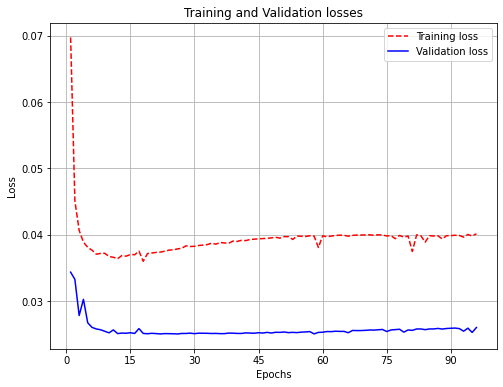

<Figure size 576x432 with 0 Axes>

In [ ]:
def metricas(history):
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]


  epochs   = range(1,len(loss)+1,1)
  plt.plot ( epochs,     loss, 'r--', label='Training loss' )
  plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  plt.title ('Training and Validation losses'   )
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.grid(True)

  plt.legend()
  plt.figure() 

metricas(history)

In [ ]:
n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_train1)):
  xt= x_train1[n][0]
  yt= y_train1[n]
  y=model.predict(np.array([x_train1[n]]))[0]
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))
  mape = np.divide(abs(yt-y), yt, out=np.zeros_like(abs(yt-y)), where=abs(yt)>=1).mean()
  mae = mean_absolute_error(yt,y)
  rmse = mean_squared_error(yt,y)**0.5

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
tMAPE =np.array(MAPE).mean()
tMAE =np.array(MAE).mean()
tRMSE =np.array(RMSE).mean()

n=0
MAPE = []
MAE = []
RMSE = []
for i in range(len(x_val1)):
  xt= x_val1[n][0]
  yt= y_val1[n]
  y=model.predict(np.array([x_val1[n]]))[0]
  mape= ((y-yt).mean())*100
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))
  mape = np.divide(abs(yt-y), yt, out=np.zeros_like(abs(yt-y)), where=abs(yt)>=1).mean()
  mae = mean_absolute_error(yt,y)
  rmse = mean_squared_error(yt,y)**0.5

  MAPE.append(mape)
  MAE.append(mae)
  RMSE.append(rmse)
  n+=1
  
vMAPE =np.array(MAPE).mean()
vMAE =np.array(MAE).mean()
vRMSE =np.array(RMSE).mean()

In [ ]:
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(tMAE,tMAPE,tRMSE))
print("----------------------------------")
print("|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación")
print("----------------------------------")
print("%9.4f%12.4f%12.4f"%(vMAE,vMAPE,vRMSE))
print("----------------------------------")

----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  65.8973      0.3589    114.8086
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  40.3020      0.1620     76.1972
----------------------------------


----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de entrenamiento
----------------------------------
  50.9635      0.4597     85.7009
----------------------------------
|  MAE   |   MAPE[%] |       RMSE  |    <-------- Promedio de errores del set completo de validación
----------------------------------
  46.8416      0.6658     80.3146
----------------------------------

**CON LOS DATOS DE ENTRENAMIENTO**

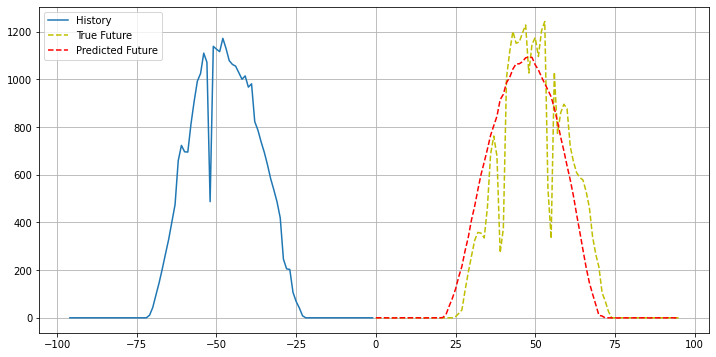

El MAPE para un horizonte de 24h es: 0.1710824374016584 %


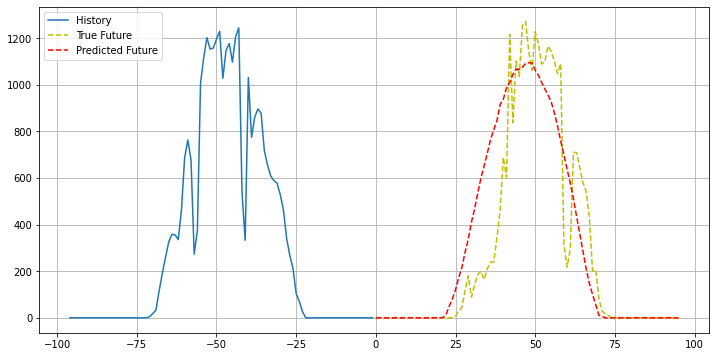

El MAPE para un horizonte de 24h es: 1.9764822953168764 %


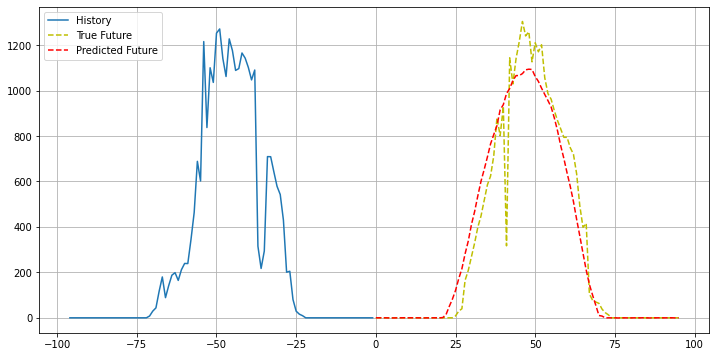

El MAPE para un horizonte de 24h es: 0.26299298810212246 %


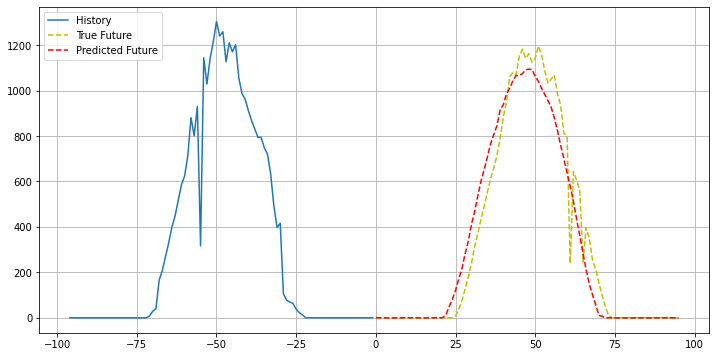

El MAPE para un horizonte de 24h es: 0.38696118185088146 %


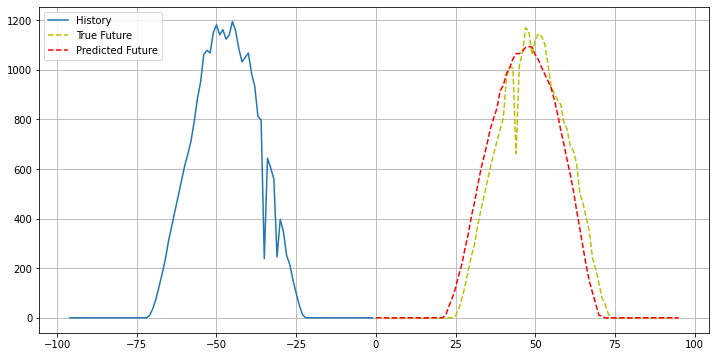

El MAPE para un horizonte de 24h es: 0.21194461850585128 %


In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_train1[n][0]
  yt= y_train1[n]
  y=model.predict(np.array([x_train1[n]]))[0]
  mae= abs((y-yt).mean())
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))

  multi_step_plot(xt[0], yt[0], y[0])
  print('El MAPE para un horizonte de 24h es:',mae*100,'%')
  n+=1

**CON LOS DATOS DE VALIDACIÓN**

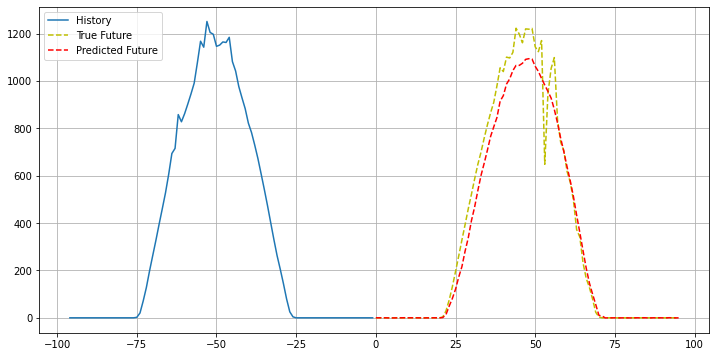

El MAPE para un horizonte de 24h es: 1.9511684163413399 %


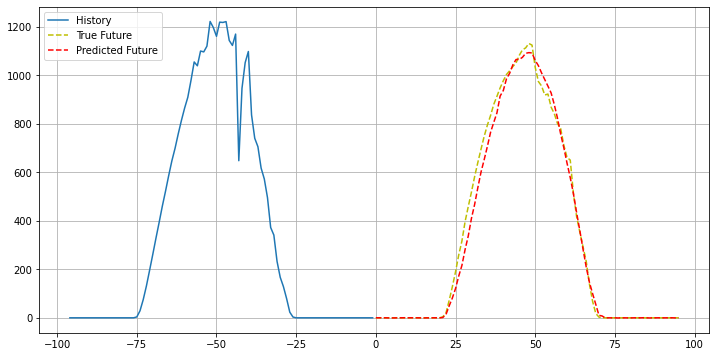

El MAPE para un horizonte de 24h es: 0.874352536932235 %


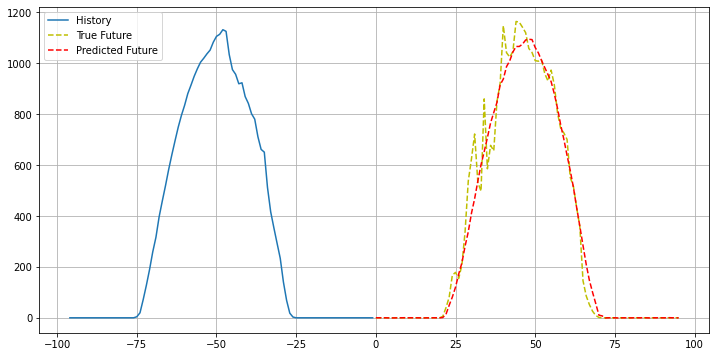

El MAPE para un horizonte de 24h es: 0.42052908153524726 %


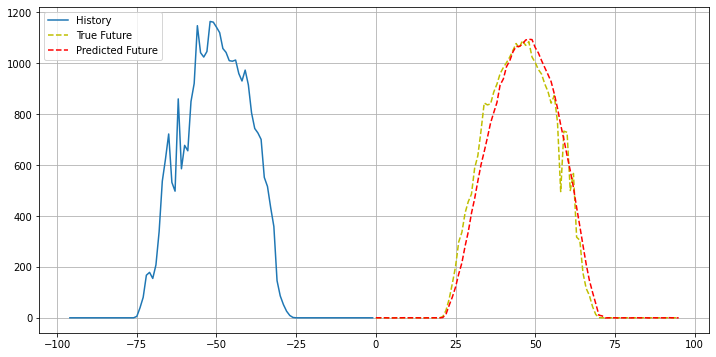

El MAPE para un horizonte de 24h es: 0.35666165507998276 %


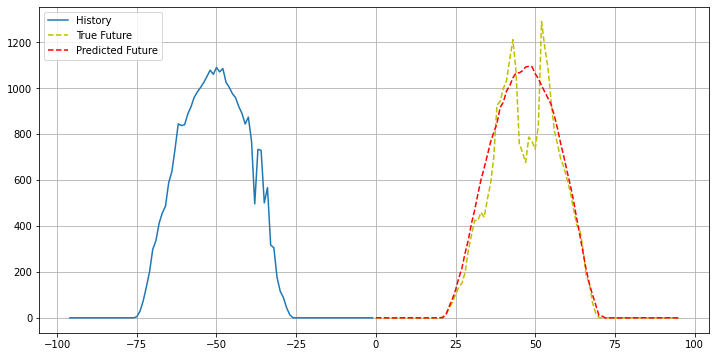

El MAPE para un horizonte de 24h es: 1.9355782725640485 %


In [ ]:
STEP = 1
n=0
for i in range(5):
  xt= x_val1[n][0]
  yt= y_val1[n]
  y=model.predict(np.array([x_val1[n]]))[0]
  mae= abs((y-yt).mean())
  xt= scaler.inverse_transform(xt.reshape((96,1))).reshape((1,96))
  yt= scaler.inverse_transform(yt.reshape((96,1))).reshape((1,96)) 
  y=scaler.inverse_transform(y.reshape((96,1))).reshape((1,96))

  multi_step_plot(xt[0], yt[0], y[0])
  print('El MAPE para un horizonte de 24h es:',mae*100,'%')
  n+=1